In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from collections import Counter

In [4]:
ratings = pd.read_csv(r'filtered_ratings.csv')
ratings.rename(columns={'Rating': 'rating'}, inplace=True)
ratings.rename(columns={'UserID': 'userId'}, inplace=True)
ratings.rename(columns={'MovieID': 'movieId'}, inplace=True)

All_parts_objects = pd.read_csv(r'1M_YOLO_features.csv', index_col=1)
columns_to_keep = [str(i) for i in range(80)]
movies_features = All_parts_objects[columns_to_keep]

# Remove rows where all features are 0
movies_features = movies_features[(movies_features != 0).any(axis=1)]
movies_metadata = pd.read_csv(r'1M_BERT_embeddings_tag_and_whisper_trans.csv')


unique_movieids_ratings = ratings['movieId'].unique()
unique_movieids_movies_metadata = movies_metadata['movieId'].unique()
unique_movieids_movies_features = movies_features.index.unique()

common_movieids = list(set(unique_movieids_movies_metadata) & set(unique_movieids_ratings) & set(unique_movieids_movies_features))

ratings = ratings[ratings['movieId'].isin(common_movieids)]
movies_metadata = movies_metadata[movies_metadata['movieId'].isin(common_movieids)]
movies_features = movies_features.iloc[movies_features.index.isin(common_movieids)]



# Method 1: Collaborative Filtering
user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')
item_user_matrix_filled = user_item_matrix.T.fillna(0.5)
item_similarity_cf = cosine_similarity(item_user_matrix_filled)
item_similarity_df_cf = pd.DataFrame(item_similarity_cf, index=user_item_matrix.columns, columns=user_item_matrix.columns)

# Method 2: Metadata-based Similarity
item_metadata_matrix_filled = movies_features.fillna(0)
item_similarity_metadata = cosine_similarity(item_metadata_matrix_filled)
item_similarity_df_metadata = pd.DataFrame(item_similarity_metadata, index=item_metadata_matrix_filled.index, columns=item_metadata_matrix_filled.index)
threshold = 0.3
item_similarity_df_metadata_thresholded = item_similarity_df_metadata.applymap(lambda x: x if x > threshold else 0)

# Method 3: BERT-based Similarity
def string_to_array(s):
    s = s.strip('[]')
    return np.array([float(x) for x in s.split()])

movies_metadata['bert_embedding'] = movies_metadata['bert_embedding'].apply(string_to_array)
movie_embeddings = np.stack(movies_metadata['bert_embedding'].values)
cosine_sim_bert = cosine_similarity(movie_embeddings, movie_embeddings)
item_similarity_df_bert = pd.DataFrame(cosine_sim_bert, index=movies_metadata['movieId'], columns=movies_metadata['movieId'])

# Split the ratings data into training and testing sets
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)

# Function to get k-nearest neighbors
def get_k_nearest_neighbors(item_similarity_df, movie_id, k=255):
    if movie_id not in item_similarity_df.columns:
        return pd.Index([])
    sim_scores = item_similarity_df[movie_id]
    nearest_neighbors = sim_scores.sort_values(ascending=False).index[:k]
    return nearest_neighbors

# Function to predict rating
def predict_rating(user_item_matrix, item_similarity_df, user_id, movie_id, k=255):
    nearest_neighbors = get_k_nearest_neighbors(item_similarity_df, movie_id, k)
    if nearest_neighbors.empty:
        return 0
    neighbor_ratings = user_item_matrix.loc[user_id, nearest_neighbors]
    if neighbor_ratings.isna().all():
        return 0
    return neighbor_ratings.mean()

# Evaluate at K=255 for combined predictions
K = 255


y_true_all = []
y_pred_all = []

for index, row in test_ratings.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']
    y_true_all.append(row['rating'])
    
    # Predictions from the three methods
    pred_cf = predict_rating(user_item_matrix, item_similarity_df_cf, user_id, movie_id, k=K)
    pred_metadata = predict_rating(user_item_matrix, item_similarity_df_metadata_thresholded, user_id, movie_id, k=K)
    pred_bert = predict_rating(user_item_matrix, item_similarity_df_bert, user_id, movie_id, k=K)
    
    # Combine predictions by averaging
    combined_prediction = np.mean([pred_cf, pred_metadata, pred_bert])
    y_pred_all.append(combined_prediction)

# Convert to floats
y_true_all = [float(val) for val in y_true_all]
y_pred_all = [float(val) for val in y_pred_all]

# Generate RMSE
rmse = mean_squared_error(y_true_all, y_pred_all, squared=False)
print("RMSE:", rmse)


/tmp/ipykernel_560280/2259747558.py:38: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  item_similarity_df_metadata_thresholded = item_similarity_df_metadata.applymap(lambda x: x if x > threshold else 0)


RMSE: 0.8065533328720799


/home/patel8m6/Desktop/python scripts/mldl/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [8]:
ratings['predicted_ratings'] = ratings.apply(lambda row: predict_rating(user_item_matrix, item_similarity_df_cf, row['userId'], row['movieId'], k=K), axis=1)

In [9]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 733247 entries, 1 to 997297
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   userId             733247 non-null  int64  
 1   movieId            733247 non-null  int64  
 2   rating             733247 non-null  float64
 3   Timestamp          733247 non-null  object 
 4   predicted_ratings  733247 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 33.6+ MB


In [10]:
from collections import defaultdict
import pandas as pd
import numpy as np

def precision_recall_at_k(df, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # Group the dataframe by userId
    user_groups = df.groupby('userId')

    precisions = {}
    recalls = {}

    for uid, group in user_groups:
        # Sort the group by predicted_ratings in descending order
        sorted_group = group.sort_values('predicted_ratings', ascending=False)

        # Number of relevant items
        n_rel = sum(sorted_group['rating'] >= threshold)

        # Number of recommended items in top k
        n_rec_k = sum(sorted_group['predicted_ratings'].head(k) >= threshold)

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum((sorted_group['rating'].head(k) >= threshold) & 
                              (sorted_group['predicted_ratings'].head(k) >= threshold))

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls
k=255
# Assuming your dataframe is called 'ratings'
precisions, recalls = precision_recall_at_k(ratings, k, threshold=3.5)

# Calculate average precision and recall
avg_precision = np.mean(list(precisions.values()))
avg_recall = np.mean(list(recalls.values()))

print(f"Average Precision@{k}: {avg_precision:.4f}")
print(f"Average Recall@{k}: {avg_recall:.4f}")

Average Precision@255: 0.8734
Average Recall@255: 0.8693


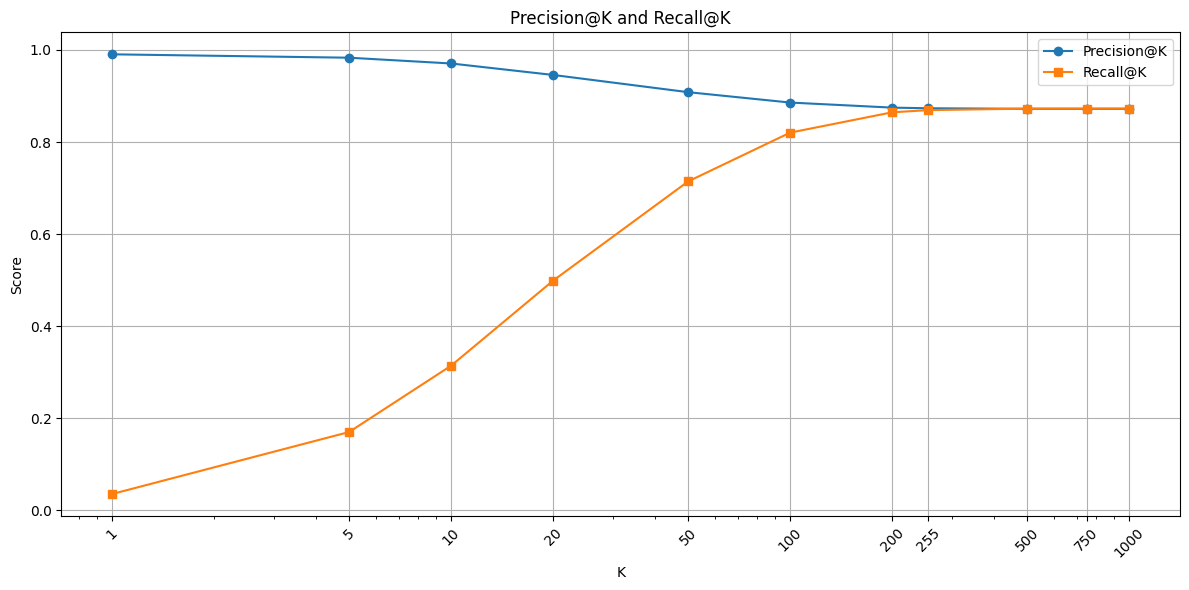

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def precision_recall_at_k(df, k=10, threshold=3.5):
    user_groups = df.groupby('userId')
    precisions = {}
    recalls = {}
    for uid, group in user_groups:
        sorted_group = group.sort_values('predicted_ratings', ascending=False)
        n_rel = sum(sorted_group['rating'] >= threshold)
        n_rec_k = sum(sorted_group['predicted_ratings'].head(k) >= threshold)
        n_rel_and_rec_k = sum((sorted_group['rating'].head(k) >= threshold) & 
                              (sorted_group['predicted_ratings'].head(k) >= threshold))
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    return np.mean(list(precisions.values())), np.mean(list(recalls.values()))

# Assuming your dataframe is called 'ratings'
k_values = [1, 5, 10, 20, 50, 100, 200, 255,500,750,1000]
precisions = []
recalls = []

for k in k_values:
    p, r = precision_recall_at_k(ratings, k=k, threshold=3.5)
    precisions.append(p)
    recalls.append(r)

# Create the graph
plt.figure(figsize=(12, 6))
plt.plot(k_values, precisions, marker='o', label='Precision@K')
plt.plot(k_values, recalls, marker='s', label='Recall@K')
plt.xlabel('K')
plt.ylabel('Score')
plt.title('Precision@K and Recall@K')
plt.legend()
plt.grid(True)
plt.xscale('log')  # Use log scale for x-axis to better show lower K values
plt.xticks(k_values, k_values, rotation=45)  # Show all K values on x-axis
plt.tight_layout()
plt.show()

In [13]:
# Assuming your dataframe is called 'ratings'
k_values = [1, 5, 10, 20, 50, 100, 200, 255,500,750,1000]
recalls

[0.03552628743149714,
 0.1701107753345947,
 0.31428393680165573,
 0.49909226510055277,
 0.7144225933982883,
 0.8204566410799241,
 0.8645997969891258,
 0.869340251665838,
 0.8725932806036403,
 0.8727611877282054,
 0.8727960638351177]